# Lac Pavin community metabolism

In [22]:
import os, glob, re
import pandas as pd
import numpy as np
import subprocess as sp
import seaborn as sns
from Bio import SeqIO
import matplotlib.pyplot as plt
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor

import warnings
warnings.filterwarnings('ignore')

In [23]:
def cmdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def scaffold(gene):
    if gene != "None":
        try: return re.search("(.+?)_[0-9]+$", gene).group(1)
        except: print(gene)

def encode(path):
    return "A" + "".join(os.path.basename(path).split("_")[1:3])      

In [24]:
def categorize(sample_name):
    
    if "SED" in sample_name:
        return "sediment"
    elif "12" in sample_name:
        return "shallow"
    elif "70" in sample_name or "90" in sample_name:
        return "anoxic zone"
    else: return "interface"

In [25]:
rootdir = "/groups/banfield/projects/environmental/LacPavin/analysis/"

# prep data

### read in data sources

In [72]:
# genome metadata
metadata = pd.read_csv(rootdir + "tables/jaffe_table_s1_curated.tsv", sep="\t")
metadata.head()

,genome_name,sample,cpr_dpann,curated_taxonomy,ggkbase_taxonomy,gtdbtk_taxonomy,bin_length,num_scaffolds,gc_perc,checkm_completeness,checkm_redundancy,gunc_phylum_css
0,LacPavin_0920_SED5_Archaea_52_7,LacPavin_0920_SED5,False,Altiarchaeota,None,d__Archaea;p__Altarchaeota;c__Altarchaeia;o__I...,1078181,207,52.03,77.96,0.00,0.12
1,LacPavin_0920_SED3_Methanomicrobiales_54_13,LacPavin_0920_SED3,False,Euryarchaeota,"Methanomicrobiales, Methanomicrobia, Euryarcha...",d__Archaea;p__Halobacteriota;c__Methanomicrobi...,1833841,107,54.38,84.64,0.33,0.12
2,LacPavin_0920_WC90_Methanomicrobiales_50_10,LacPavin_0920_WC90,False,Euryarchaeota,"Methanomicrobiales, Methanomicrobia, Euryarcha...",d__Archaea;p__Halobacteriota;c__Methanomicrobi...,3250097,402,49.75,98.69,0.65,0.33
3,LacPavin_0419_WC70L_Methanoregula_51_15,LacPavin_0419_WC70L,False,Euryarchaeota,"Methanoregula, Methanomicrobiales, Methanomicr...",d__Archaea;p__Halobacteriota;c__Methanomicrobi...,2077268,518,51.30,91.65,7.14,0.26
4,LacPavin_0920_SED3_Methanoregula_49_39,LacPavin_0920_SED3,False,Euryarchaeota,"Methanoregula, Methanomicrobiales, Methanomicr...",d__Archaea;p__Halobacteriota;c__Methanomicrobi...,1770585,229,49.44,84.94,3.18,0.00


### repredict genes w/ single

In [ ]:
cmdir(rootdir + "metabolism/proteins")
cmdir(rootdir + "metabolism/proteins_clean")

In [ ]:
def execute(call):
    sp.call(call, shell=True)

In [ ]:
calls = []

for key, row in metadata.iterrows():
    
    if row["cpr_dpann_lineage"] in ["Absconditabacteria", "Gracilibacteria"]:
        ttable = "25"
    else: ttable = "11"
    
    genome_path = glob.glob(rootdir + "genomes/renamed_genomes/" + row["genome_name"] + ".fna")
    call = "prodigal -a %s -g %s -i %s -p single" %(rootdir + "metabolism/proteins/" + \
            row["genome_name"] + ".faa", ttable, genome_path[0])
    calls.append(call)

In [ ]:
with ProcessPoolExecutor(20) as executor:
    executor.map(execute, calls)

In [ ]:
# write clean versions
for proteome in glob.glob(rootdir + "metabolism/proteins/*"):
    with open(proteome.replace("proteins", "proteins_clean"), "w") as out:
        for record in SeqIO.parse(open(proteome), "fasta"):
            out.write(">%s\n%s\n" %(record.description.split(" ")[0], str(record.seq)))

# metabolic HMMs

In [ ]:
cmdir(rootdir + "metabolism")

### read in kofamscan

In [29]:
def parse_kofamscan(path):
   
    buffer = []
    for line in open(path).readlines():
        if "#" not in line:
            # hilariously long regex
            m = re.search("[* ]*([\S]+)\s+([\S]+)\s+([0-9.-]+)\s+" + \
                "([0-9.-]+)\s+([0-9.+-e]+)\s(.+?$)", line.strip())
            try:
                buffer.append(m.groups())
            except:
                print(line)

    kodf = pd.DataFrame.from_records(buffer, columns =["gene", "ko", "threshold", "score", "eval", "def"]) 
    buffer=[]
    return kodf

In [30]:
# filter for significance
kodf = parse_kofamscan(rootdir + "pclust/other/kofamscan.latest.txt")
kodf["eval"] = kodf["eval"].apply(lambda x: float(x))
kodf["score"] = kodf["score"].apply(lambda x: float(x))
kodf = kodf[kodf["eval"] < 1e-6]
# get best hit per gene based on score
kfilt = kodf.sort_values('score', ascending=False).drop_duplicates("gene")
kfilt.head()

,gene,ko,threshold,score,eval,def
19595267,LacPavin_0920_SED2_scaffold_32357_55,K16095,10534.47,8208.5,0.0,bacitracin synthase 3
19554984,LacPavin_0920_SED2_scaffold_1239145_2,K16095,10534.47,6938.4,0.0,bacitracin synthase 3
19641331,LacPavin_0920_SED2_scaffold_259230_5,K16095,10534.47,6716.9,0.0,bacitracin synthase 3
19587253,LacPavin_0920_SED2_scaffold_1873334_17,K16095,10534.47,5089.9,0.0,bacitracin synthase 3
19636246,LacPavin_0920_SED2_scaffold_440833_5,K16124,12493.27,5071.0,0.0,tyrocidine synthetase III


In [31]:
scaf2bin = {}
for genome in glob.glob(rootdir + "genomes/renamed_genomes/*"):
    for record in SeqIO.parse(open(genome), "fasta"):
        scaf2bin[record.description.split(" ")[0]] = os.path.basename(genome).replace(".fna", "")

In [32]:
# add scaffold and bin info
kfilt["scaffold"] = kfilt["gene"].apply(scaffold)
kfilt["bin"] = kfilt["scaffold"].map(scaf2bin)
kfilt.head()

,gene,ko,threshold,score,eval,def,scaffold,bin
19595267,LacPavin_0920_SED2_scaffold_32357_55,K16095,10534.47,8208.5,0.0,bacitracin synthase 3,LacPavin_0920_SED2_scaffold_32357,LacPavin_0920_SED2_Bacteria_46_26
19554984,LacPavin_0920_SED2_scaffold_1239145_2,K16095,10534.47,6938.4,0.0,bacitracin synthase 3,LacPavin_0920_SED2_scaffold_1239145,LacPavin_0920_SED2_Bacteria_46_26
19641331,LacPavin_0920_SED2_scaffold_259230_5,K16095,10534.47,6716.9,0.0,bacitracin synthase 3,LacPavin_0920_SED2_scaffold_259230,LacPavin_0920_SED2_Bacteria_46_26
19587253,LacPavin_0920_SED2_scaffold_1873334_17,K16095,10534.47,5089.9,0.0,bacitracin synthase 3,LacPavin_0920_SED2_scaffold_1873334,LacPavin_0920_SED2_Bacteria_46_26
19636246,LacPavin_0920_SED2_scaffold_440833_5,K16124,12493.27,5071.0,0.0,tyrocidine synthetase III,LacPavin_0920_SED2_scaffold_440833,LacPavin_0920_SED2_Bacteria_46_26


### get HMM info/thresholds

In [33]:
thresholds = {"K14028": 1000, "K15228": 100, "K15229": 100,
              "K00148": 391.20, "K01070": 80.20, "K00121": 550,
              "K00153": 513, "K10713": 90, "K10944":100,
              "K10945": 122, "K10946": 139.20, "K16160": 198.47,
              "K16162": 61.43, "K00399":0, "K00401": 0, "K03421": 0,
              "K01601": 500, "K15230": 300, "K15231":200, "K00123": 798.80,
              "K22515": 580, "K00124": 141.3, "K22516": 628.5, "K00125":210,
             "K03518": 85.9, "K03519": 227.3, "K03520": 128.5, "K14469":3000,
             "K14468": 2000, "K14466":1000, "K00194":184.67, "K00197": 201, "K00198": 400}

categories = ["C1 metabolism", "Methane metabolism", "Carbon fixation"]

In [34]:
hmm_dict = {}
kos_flat = []
flag=False

for key, row in pd.read_csv(rootdir + "metabolism/hmm_table_template.txt", sep="\t").fillna("None").iterrows():
    
    if (row["Category"] in categories) and (row["Corresponding KO"] != "None"):
        
        hmm_dict[str(row["#Entry"])] = row["Corresponding KO"].split(", ")
        
        for i, ko in enumerate(row["Corresponding KO"].split(", ")):
            
            kos_flat.append(ko)
            
            if (ko not in thresholds.keys()) and \
                (len(kfilt[kfilt["ko"]==ko]) > 0):
                
                flag = True
                ko_hits_sub = kfilt[kfilt["ko"]==ko].sort_values("score", ascending=False).reset_index()
                ko_hits_sub["position"] = ko_hits_sub.index

                plt.figure(figsize=[8, 4])
                sns.scatterplot("position", "score", data=ko_hits_sub, alpha=0.5)
                if "K" in row["Hmm file"]:
                    metabolic_threshold = float(row["Hmm detecting threshold"].split(",")[i].split("|")[0])
                    plt.axhline(metabolic_threshold, color="red")
                plt.axhline(float(ko_hits_sub["threshold"].iloc[0]), color="blue")
                plt.title(ko) 
    
    if flag== True:
        break

### refine tricky HMM thresholds

In [ ]:
cmdir(rootdir + "metabolism/hmm_refine")

In [13]:
to_revisit = ["K10713", "K14028", "K00123",
            "K00124", "K22516", "K03518",
            "K03519", "K03520", "K00194", "K00197"]

In [39]:
# downsample kegg results
subfilt = kfilt[kfilt["ko"].isin(kos_flat)]

In [ ]:
sh = open(rootdir + "metabolism/hmm_refine/process.sh", "w")
sh.write("export OMP_NUM_THREADS=20\n")
    
for ko in to_revisit:

    # build the tree
    csv = rootdir + "metabolism/hmm_refine/" + ko + ".txt"
    subfilt[subfilt["ko"]==ko]["gene"].to_csv(csv, header=None, index=False)
    seqdb = rootdir + "metabolism/all_genomes_but_cpr.faa"
    fasta = csv.replace(".txt", ".faa")
    sh.write("pullseq -n %s -i %s > %s\n" %(csv, seqdb, fasta))
    aln = csv.replace(".txt", ".mafft")
    sh.write("mafft --auto --thread 20 %s > %s\n" %(fasta, aln))
    tre = csv.replace(".txt", ".tre")
    sh.write("FastTreeMP %s > %s\n" %(aln, tre))
    
    # generate the tree annotation
    with open(rootdir + "metabolism/hmm_refine/" + ko + ".itol.txt", "w") as out:
        out.write("DATASET_SIMPLEBAR\nSEPARATOR COMMA\n")
        out.write("DATASET_LABEL,%s\nCOLOR,#ff0000\nDATA\n" %(ko))
        for key, row in subfilt[subfilt["ko"]==ko].iterrows():
            out.write("%s,%s\n" %(row["gene"], row["score"]))

sh.close()

In [40]:
subfilt["manual_threshold"] = subfilt["ko"].map(thresholds).fillna("None")
kegg_final = subfilt[subfilt["score"]>subfilt["manual_threshold"]]

### probe genomes

In [134]:
hmm_info = defaultdict(list)
template = pd.read_csv(rootdir + "metabolism/hmm_table_template_2.txt", sep="\t").fillna("None")

for category in categories:
    
    count=0
    total = len(template[template["Category"]==category])
    
    for key, row in template[template["Category"]==category].iterrows():
        
        if "Rubisco" not in row["Function"]:
            
            # get gene-kegg ids
            entries = [entry.lstrip("0") for entry in row["Entry"].split("||")]
            genes = []

            for gene in row["Gene abbreviation"].split("||"):

                # if there are subunits
                if re.search("[a-z]{3}[A-Z]{2,}", gene):
                    for subunit in gene[3:]:
                        genes.append(gene[0:3] + subunit)
                else: genes.append(gene)
            
            kos = [hmm_dict[item][0] for item in entries]

            # now probe the genomes
            for bin in kfilt["bin"].unique():

                hit_count = 0
                hit_kos = []
                hit_ids = []

                for ko in kos:

                    subtable = kegg_final[(kegg_final["bin"]==bin) &
                                    (kegg_final["ko"]==ko)]
                    if len(subtable) > 0:
                        hit_count +=1
                        hit_kos.append(ko)
                        hit_ids.append(subtable["gene"].iloc[0])

                # now add it to the table
                hmm_info["category"].append(category)
                hmm_info["function"].append(row["Function"])
                hmm_info["genome_name"].append(bin)
                hmm_info["hit_count"].append(hit_count)
                hmm_info["hit_total"].append(len(entries))
                hmm_info["hit_perc"].append(hit_count/len(entries)*100)
                hmm_info["hit_kos"].append(",".join(hit_kos))
                hmm_info["hit_ids"].append(",".join(hit_ids))
        
        count+=1
        print('processed %d of %d in %s\r'%(count, total, row["Category"]), end="")
            
hmm_df = pd.DataFrame(hmm_info).query("hit_count!=0")
hmm_df.head()

,category,function,genome_name,hit_count,hit_total,hit_perc,hit_kos,hit_ids
7,C1 metabolism,Methanol oxidation,LacPavin_0419_WC53_Methylobacter_49_11,1,2,50.0,K14028,LacPavin_0419_WC53_scaffold_317686_9
10,C1 metabolism,Methanol oxidation,LacPavin_0920_WC57_Methylococcales_48_27,1,2,50.0,K14028,LacPavin_0920_WC57_scaffold_335736_9
117,C1 metabolism,Methanol oxidation,LacPavin_0818_WC45_Methylococcales_44_10,1,2,50.0,K14028,LacPavin_0818_WC45_scaffold_847431_23
138,C1 metabolism,Methanol oxidation,LacPavin_0419_WC70S_Methylobacterium_71_26,1,2,50.0,K14028,LacPavin_0419_WC70S_scaffold_724202_8
633,C1 metabolism,Methyl amine -> formaldehyde,LacPavin_0419_WC53_Rhodococcus_63_12,1,2,50.0,K15228,LacPavin_0419_WC53_scaffold_419709_6


### define pathway presence

In [135]:
counts = {"Formate oxidation": 2, "Aerobic CO oxidation": 3,
          "Wood Ljungdahl pathway": 2}

In [136]:
hmm_df["count_threshold"] = hmm_df["function"].apply(lambda x: counts[x] if x in counts else 1)
hmm_df = hmm_df[hmm_df["hit_count"]>=hmm_df["count_threshold"]]

### add rubisco

In [137]:
rub_data = pd.read_csv(rootdir + "tables/rubisco_metadata.tsv", sep="\t")
rub_data.head()

,gene,scaffold,hmm,contig_taxonomy,bin,revised_taxonomy,revised_form
0,LacPavin_0419_WC53_scaffold_176139_17,LacPavin_0419_WC53_scaffold_176139,rubisco_form_I,Proteobacteria,LacPavin_0419_WC53_Rhizobiales_62_6,Proteobacteria,I
1,LacPavin_0920_WC70_scaffold_73101_221,LacPavin_0920_WC70_scaffold_73101,rubisco_form_I,Proteobacteria,LacPavin_0920_WC70_Gammaproteobacteria_66_37,Proteobacteria,I
2,LacPavin_0920_WC90_scaffold_373145_83,LacPavin_0920_WC90_scaffold_373145,rubisco_form_I,Proteobacteria,LacPavin_0920_WC90_Mesorhizobium_64_12,Proteobacteria,I
3,LacPavin_0920_WC12_scaffold_364754_8,LacPavin_0920_WC12_scaffold_364754,rubisco_form_I,Proteobacteria,None,Proteobacteria,I
4,LacPavin_0920_WC70_scaffold_1243547_9,LacPavin_0920_WC70_scaffold_1243547,rubisco_form_I,Proteobacteria,LacPavin_0920_WC70_Gammaproteobacteria_68_44,Proteobacteria,I


In [138]:
rub_info = defaultdict(list)

for key, row in rub_data.query("bin!='None'").iterrows():
    
    if row["revised_form"] in ["I", "II"]:
        
        rub_info["category"].append("Carbon fixation")
        rub_info["function"].append("Calvin cycle")
        rub_info["genome_name"].append(row["bin"])
        rub_info["hit_kos"].append("K01601")
        rub_info["hit_ids"].append(row["gene"])
        
        for field in ["hit_count", "hit_total", "hit_perc"]:
            rub_info[field].append("None")

rub_df = pd.DataFrame(rub_info)
rub_df.head()

,category,function,genome_name,hit_kos,hit_ids,hit_count,hit_total,hit_perc
0,Carbon fixation,Calvin cycle,LacPavin_0419_WC53_Rhizobiales_62_6,K01601,LacPavin_0419_WC53_scaffold_176139_17,None,None,None
1,Carbon fixation,Calvin cycle,LacPavin_0920_WC70_Gammaproteobacteria_66_37,K01601,LacPavin_0920_WC70_scaffold_73101_221,None,None,None
2,Carbon fixation,Calvin cycle,LacPavin_0920_WC90_Mesorhizobium_64_12,K01601,LacPavin_0920_WC90_scaffold_373145_83,None,None,None
3,Carbon fixation,Calvin cycle,LacPavin_0920_WC70_Gammaproteobacteria_68_44,K01601,LacPavin_0920_WC70_scaffold_1243547_9,None,None,None
4,Carbon fixation,Calvin cycle,LacPavin_0818_WC45_Mycobacterium_66_14,K01601,LacPavin_0818_WC45_scaffold_2432_6,None,None,None


In [139]:
hmm_df = pd.concat([hmm_df, rub_df])

### check pmo

In [ ]:
cmdir(rootdir + "metabolism/pmo")

In [ ]:
# write out LP sequences
subfilt.query("ko=='K10944'")["gene"].to_csv(rootdir + "metabolism/pmo/pmoa.txt", index=False, header=None)

Manually pullseq.

In [ ]:
refs = "/groups/banfield/projects/multienv/amoa/New_Analysis/Specific_Analysis/AMO_Analysis/new_alignments/amoA_pmoA/06_amoA_pmoA_NovAndRef_GenomeName.faa"

with open(rootdir + "metabolism/pmo/concat_sequences.faa", "w") as out:
    
    headers = []
    for record in SeqIO.parse(open(refs), "fasta"):
        name = "_".join(record.description.split("_")[:-1]) if "operon" in \
                        record.description else record.description
        if name not in headers:
            out.write(">%s\n%s\n" %(name, str(record.seq)))
            headers.append(name)

    for record in SeqIO.parse(open(rootdir + "metabolism/pmo/pmoa.faa"), "fasta"):
        out.write(">%s\n%s\n" %(record.description, str(record.seq)))

Then manually align, tree build...

In [ ]:
# read sequence metadata
md = pd.read_csv(rootdir + "metabolism/pmo/diamond_et_al_table_s3.csv")
colors = {val: sns.color_palette("Set3").as_hex()[i] for i,val in enumerate(md["Group"].unique())}
colors

In [ ]:
# create itol info
with open(rootdir + "metabolism/pmo/pmo.itol.txt", "w") as itol:
    itol.write("TREE_COLORS\nSEPARATOR TAB\nDATA\n")
    for key, row in md.iterrows():
        itol.write(row["Name"] + "\trange\t" + colors[row["Group"]] + "\t" + row["Group"] + "\n")

In [140]:
# integrate two versions of methane oxidation
hmm_df["function_clean"] = hmm_df["function"].apply(lambda x: x.split(" - ")[0] if "Methane oxidation" in x else x)
hmm_df_final = hmm_df.sort_values(["genome_name", "hit_total"], ascending=[False,False]).drop_duplicates(["category", "function_clean", "genome_name"])

In [141]:
# write out raw version for later
hmm_df.to_csv(rootdir + "tables/hmm_df.tsv", sep="\t", index=False)

# plot

In [142]:
hmm_df_final = pd.read_csv(rootdir + "tables/hmm_df.tsv", sep="\t")

### prep

In [143]:
hmm_df_final["value"] = 1
hmm_df_final = hmm_df_final.merge(metadata[["genome_name", "curated_taxonomy"]], on="genome_name", how="left")
hmm_df_final.head()

,category,function,genome_name,hit_count,hit_total,hit_perc,hit_kos,hit_ids,count_threshold,function_clean,value,curated_taxonomy
0,C1 metabolism,Methanol oxidation,LacPavin_0419_WC53_Methylobacter_49_11,1,2,50.0,K14028,LacPavin_0419_WC53_scaffold_317686_9,1.0,Methanol oxidation,1,Proteobacteria
1,C1 metabolism,Methanol oxidation,LacPavin_0920_WC57_Methylococcales_48_27,1,2,50.0,K14028,LacPavin_0920_WC57_scaffold_335736_9,1.0,Methanol oxidation,1,Proteobacteria
2,C1 metabolism,Methanol oxidation,LacPavin_0818_WC45_Methylococcales_44_10,1,2,50.0,K14028,LacPavin_0818_WC45_scaffold_847431_23,1.0,Methanol oxidation,1,Proteobacteria
3,C1 metabolism,Methanol oxidation,LacPavin_0419_WC70S_Methylobacterium_71_26,1,2,50.0,K14028,LacPavin_0419_WC70S_scaffold_724202_8,1.0,Methanol oxidation,1,Proteobacteria
4,C1 metabolism,Methyl amine -> formaldehyde,LacPavin_0419_WC53_Rhodococcus_63_12,1,2,50.0,K15228,LacPavin_0419_WC53_scaffold_419709_6,1.0,Methyl amine -> formaldehyde,1,Actinobacteria


In [81]:
# read in coverage info - 95% id and 50% breadth
coverage_table = pd.read_csv(rootdir + "genomes/remapping/coverage_table.95.csv", sep="\t")
coverage_table = coverage_table[coverage_table["Covered Fraction"]>=0.50]
coverage_table.head()

,Sample,Genome,Read Count,Mean,Covered Fraction,Length,RPKM
0,genomes_R0419WC53.sorted,LacPavin_0818_WC50_Rhizobiales_65_19,28591,1.072806,0.624130,3791592,0.156232
2,genomes_R0419WC53.sorted,LacPavin_0818_WC50_Alphaproteobacteria_64_9,107597,2.877554,0.922890,5309877,0.419834
8,genomes_R0419WC53.sorted,LacPavin_0920_WC57_Actinobacteria_51_13,666761,49.802390,0.998688,1956235,7.061735
10,genomes_R0419WC53.sorted,LacPavin_0818_WC50_Planctomycetales_55_36,446817,12.229828,0.998753,5237937,1.767387
11,genomes_R0419WC53.sorted,LacPavin_0419_WC53_Gammaproteobacteria_39_9,123126,8.266907,0.998887,2162034,1.179912


In [82]:
# calculate relative coverage
covsums = coverage_table.groupby(["Sample"], as_index=False).aggregate({"Mean":"sum"})
covsums.columns = ["Sample", "total_genome_coverage"]
covmerge = coverage_table.merge(covsums, how="left", on= "Sample")
covmerge["relative_coverage"] = covmerge.apply(lambda x: x["Mean"]/x["total_genome_coverage"], axis=1)
covmerge["perc_relative_coverage"] = covmerge["relative_coverage"].apply(lambda x: 100*x)
# subset
covsub = covmerge[["Sample", "Genome", "perc_relative_coverage"]]
covsub["compartment"] = covsub["Sample"].apply(categorize)
covsub.head()

,Sample,Genome,perc_relative_coverage,compartment
0,genomes_R0419WC53.sorted,LacPavin_0818_WC50_Rhizobiales_65_19,0.049718,interface
1,genomes_R0419WC53.sorted,LacPavin_0818_WC50_Alphaproteobacteria_64_9,0.133356,interface
2,genomes_R0419WC53.sorted,LacPavin_0920_WC57_Actinobacteria_51_13,2.308019,interface
3,genomes_R0419WC53.sorted,LacPavin_0818_WC50_Planctomycetales_55_36,0.566773,interface
4,genomes_R0419WC53.sorted,LacPavin_0419_WC53_Gammaproteobacteria_39_9,0.383118,interface


In [83]:
merged = covsub.merge(hmm_df_final[["category", "function_clean", "genome_name", "value", "curated_taxonomy"]], how="right", left_on="Genome", right_on="genome_name").drop_duplicates()
merged.head()

,Sample,Genome,perc_relative_coverage,compartment,category,function_clean,genome_name,value,curated_taxonomy
0,genomes_R0419WC53.sorted,LacPavin_0419_WC53_Methylobacter_49_11,0.481252,interface,C1 metabolism,Methanol oxidation,LacPavin_0419_WC53_Methylobacter_49_11,1,Proteobacteria
1,genomes_R0419WC70L.sorted,LacPavin_0419_WC53_Methylobacter_49_11,0.426887,anoxic zone,C1 metabolism,Methanol oxidation,LacPavin_0419_WC53_Methylobacter_49_11,1,Proteobacteria
2,genomes_R0419WC70S.sorted,LacPavin_0419_WC53_Methylobacter_49_11,0.364673,anoxic zone,C1 metabolism,Methanol oxidation,LacPavin_0419_WC53_Methylobacter_49_11,1,Proteobacteria
3,genomes_R0419WC90.sorted,LacPavin_0419_WC53_Methylobacter_49_11,0.047899,anoxic zone,C1 metabolism,Methanol oxidation,LacPavin_0419_WC53_Methylobacter_49_11,1,Proteobacteria
4,genomes_R0818WC45.sorted,LacPavin_0419_WC53_Methylobacter_49_11,3.830586,interface,C1 metabolism,Methanol oxidation,LacPavin_0419_WC53_Methylobacter_49_11,1,Proteobacteria


In [84]:
merged_gb = merged.groupby(["compartment", "Sample","category", "function_clean"], as_index=False).aggregate({"perc_relative_coverage":"sum"}).sort_values("Sample")
merged_gb.head()

,compartment,Sample,category,function_clean,perc_relative_coverage
51,interface,genomes_R0419WC53.sorted,C1 metabolism,Formate oxidation,7.396251
49,interface,genomes_R0419WC53.sorted,C1 metabolism,Aerobic CO oxidation,27.285291
52,interface,genomes_R0419WC53.sorted,C1 metabolism,Methanol oxidation,0.529753
53,interface,genomes_R0419WC53.sorted,C1 metabolism,Methyl amine -> formaldehyde,0.486464
54,interface,genomes_R0419WC53.sorted,Carbon fixation,Calvin cycle,1.475214


### by sample

In [85]:
# define sample order
sorted_samples = sorted([item for item in merged_gb["Sample"].unique() if \
        "SED" not in item], key=lambda x: x.split("_")[1][7:9], reverse=False) + \
        sorted([item for item in merged_gb["Sample"].unique() if "SED" in item], reverse=False)
sample_order = {val:i for i, val in enumerate(sorted_samples)}
merged_gb["sample_order"] = merged_gb["Sample"].map(sample_order)

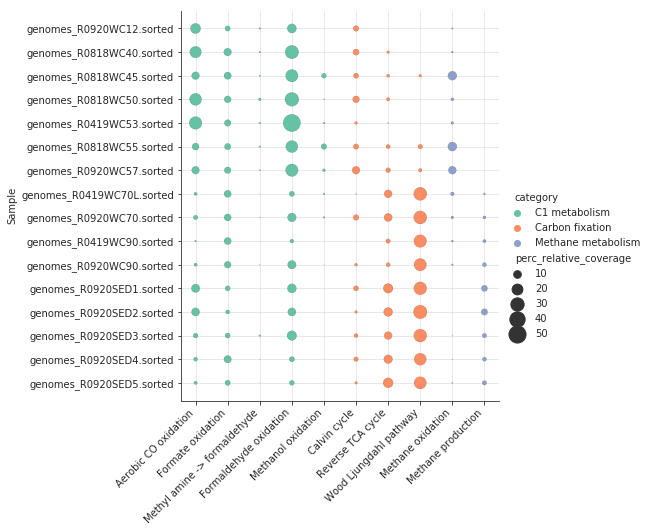

In [86]:
kws = dict(linewidth=.1, edgecolor="black")
sns.relplot(x="function_clean", y="Sample", data=merged_gb[~merged_gb["Sample"].str.contains("70S")].sort_values(["category", "sample_order"]), 
                hue="category", palette="Set2", size="perc_relative_coverage", sizes=(0,300), height=6, 
                aspect=1.25,alpha=1, **kws, legend="brief")
# add in lines
for i in range(0, len(merged_gb["Sample"].unique())-1):
    plt.axhline(i, color='lightgrey', linestyle='-', lw=0.5,zorder=0)
for i in range(0, len(merged_gb["function_clean"].unique())):
    plt.axvline(i, color='lightgrey', linestyle='-', lw=0.5,zorder=0)
plt.xticks(rotation=45, ha="right")
plt.xlabel("")
plt.savefig(rootdir + "figures/metabolism_by_sample.svg", format="svg")

### by compartment/phylogeny

In [87]:
# first sum rel abundance across genomes by phylum
merged_comp = merged.groupby(["curated_taxonomy", "compartment", "Sample", "category", "function_clean"], as_index=False).aggregate({"perc_relative_coverage":"sum"})
# then take mean across samples within a compartment
merged_comp2 = merged_comp.groupby(["compartment", "curated_taxonomy", "category", "function_clean"], as_index=False).aggregate({"perc_relative_coverage":"mean"})
merged_comp2.head()

,compartment,curated_taxonomy,category,function_clean,perc_relative_coverage
0,anoxic zone,Acidobacteria,C1 metabolism,Aerobic CO oxidation,0.113943
1,anoxic zone,Acidobacteria,C1 metabolism,Formaldehyde oxidation,0.432097
2,anoxic zone,Acidobacteria,C1 metabolism,Formate oxidation,0.045095
3,anoxic zone,Acidobacteria,Carbon fixation,Wood Ljungdahl pathway,0.184105
4,anoxic zone,Actinobacteria,C1 metabolism,Aerobic CO oxidation,1.266869


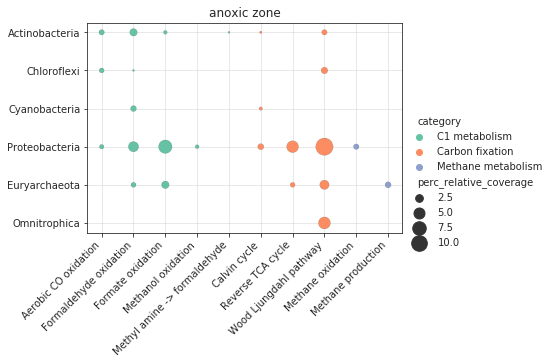

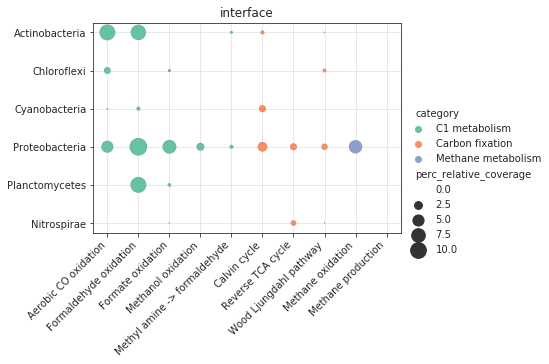

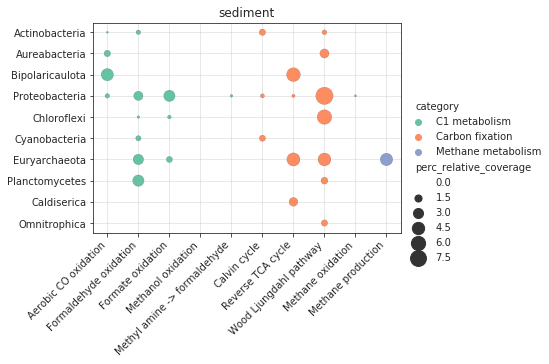

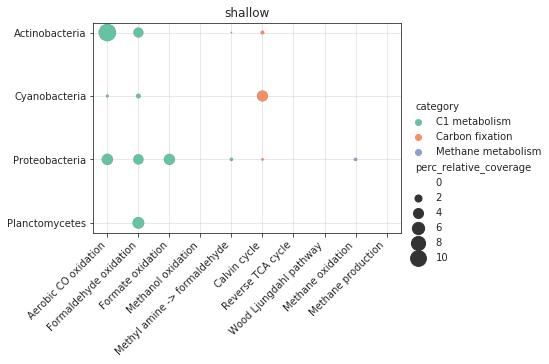

In [95]:
for compartment in merged_comp2["compartment"].unique():
    
    if compartment: #!= "shallow":
    
        raw_table = merged_comp2[merged_comp2["compartment"]==compartment]
        
        # first, filter out taxa with no fields >= 1%
        maxs = raw_table.groupby("curated_taxonomy", as_index=False).aggregate({"perc_relative_coverage":"max"})
        to_drop = maxs[maxs["perc_relative_coverage"]<=1]["curated_taxonomy"].to_list()
        filt_table = raw_table[~raw_table["curated_taxonomy"].isin(to_drop)]
        
        # fill out all metabolisms in each table
        dummies = defaultdict(list)
        
        for key, row in merged_comp2.drop_duplicates(["category", "function_clean"]).iterrows():

            if row["function_clean"] not in list(filt_table["function_clean"].unique()):

                dummies["compartment"].append(compartment)
                # choose random phylum
                dummies["curated_taxonomy"].append(filt_table["curated_taxonomy"].unique()[0])
                for field in ["category", "function_clean"]:
                    dummies[field].append(row[field])
                dummies["perc_relative_coverage"].append(0)

        mod_table = pd.concat([filt_table, pd.DataFrame(dummies)])

        # plot
        sns.set_style("ticks")
        g = sns.relplot(x="function_clean", y="curated_taxonomy", 
            data=mod_table.sort_values(["category", "function_clean"]), hue="category",
            palette="Set2", size="perc_relative_coverage", sizes=(0,300),height=3.5,
            aspect=1.75,alpha=1, **kws, legend="brief")
        
        # add in lines
        for i in range(0, len(mod_table["curated_taxonomy"].unique())):
            plt.axhline(i, color='lightgrey', linestyle='-', lw=0.5,zorder=0)
        for i in range(0, len(mod_table["function_clean"].unique())):
            plt.axvline(i, color='lightgrey', linestyle='-', lw=0.5,zorder=0)
            
        plt.xticks(rotation=45, ha="right")
        plt.xlabel("")
        plt.ylabel("")
        plt.title(compartment)
        sns.despine(top=False, right=False)
        plt.savefig(rootdir + "figures/metabolic_potential_" + \
            compartment.replace(" ", "_") + ".svg", format="svg")
        plt.show()

### methane producers

In [89]:
genomes = metadata[metadata["gtdbtk_taxonomy"].str.contains("Methano")]["genome_name"].to_list()
mcr = merged.query("function_clean=='Methane production'")["genome_name"].unique()

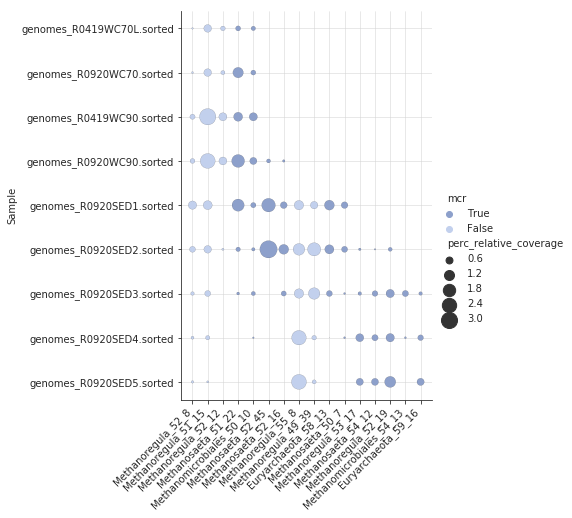

In [90]:
mp = covsub[covsub["Genome"].isin(genomes)]
mp["sample_order"] = mp["Sample"].map(sample_order)
mp["mcr"] = mp["Genome"].apply(lambda x: x in mcr)
mp["short_genome_name"] = mp["Genome"].apply(lambda x: "_".join(x.split("_")[3:]))

kws = dict(linewidth=.1, edgecolor="black")
sns.relplot(x="short_genome_name", y="Sample", data=mp[~mp["Sample"].str.contains("70S")].sort_values(["sample_order"]), 
                hue="mcr", palette={True:"#8da0cb", False:"#c2d0ed"}, size="perc_relative_coverage", sizes=(0,300), height=6, 
                aspect=1.1,alpha=1, **kws, legend="brief", hue_order=[True,False])
# add in lines
for i in range(0, len(mp["Sample"].unique())-1):
    plt.axhline(i, color='lightgrey', linestyle='-', lw=0.5,zorder=0)
for i in range(0, len(mp["short_genome_name"].unique())):
    plt.axvline(i, color='lightgrey', linestyle='-', lw=0.5,zorder=0)
plt.xticks(rotation=45, ha="right")
plt.xlabel("")
plt.savefig(rootdir + "figures/mcr_by_sample.svg", format="svg")

### supp tables

In [98]:
def revert_name(run):
    
    base = run.split("_")[1].split(".")[0]
    year = re.search("R([0-9]+)(.+)", base).group(1)
    sample = re.search("R([0-9]+)(.+)", base).group(2)
    return "LacPavin_%s_%s" %(year, sample)

In [168]:
# hmm info
hmm_raw = pd.read_csv(rootdir + "metabolism/hmm_table_template.txt", sep="\t").fillna("None")
hmm_sub = hmm_raw[(hmm_raw["Corresponding KO"].isin(kos_flat)) & \
                  (~hmm_raw["Category"].str.contains("Nitr"))][["Category", "Function", "Gene abbreviation", "Gene name", "Corresponding KO"]]
hmm_sub.columns = ["category", "function", "gene_abbreviation", "gene_name", "corresponding_ko"]
hmm_sub["manual_threshold"] = hmm_sub["corresponding_ko"].map(thresholds).fillna("not detected")
hmm_sub.to_csv(rootdir + "tables/hmm_info.tsv", sep="\t", index=False)

Modify RuBisCO manually - condense to one line.

In [144]:
# merged metab info
metab_supp_table = merged = covsub.merge(hmm_df_final[["category", "function_clean", "genome_name", "hit_kos", "hit_ids", "curated_taxonomy"]], how="right", left_on="Genome", right_on="genome_name").drop_duplicates()
metab_supp_table["sample"] = metab_supp_table["Sample"].apply(revert_name)
metab_supp_table.query("sample!='LacPavin_0419_WC70S'")[["sample", "compartment", "category", "function_clean", "genome_name", \
        "curated_taxonomy", "hit_kos", "hit_ids", "perc_relative_coverage"]].sort_values(["sample", \
        "category", "function_clean", "perc_relative_coverage"], ascending=[True, True,True,False]).to_csv(rootdir + "tables/metab_supp.tsv", sep="\t", index=False)

# protein clustering prep

In [ ]:
# concat faa for protein clustering
with open(rootdir + "metabolism/all_genomes_but_cpr.faa", "w") as out:
    
    for key, row in metadata.iterrows():
        if "Patescibacteria" not in row["gtdbtk_taxonomy"]:
            ppath = glob.glob(rootdir + "metabolism/proteins_clean/" + row["genome_name"] + ".faa")[0]
            for record in SeqIO.parse(open(ppath), "fasta"):
                out.write(">%s\n%s\n" %(record.description, str(record.seq)))

In [ ]:
# coverage for sample distribution
remapping = pd.read_csv(rootdir + "genomes/remapping/coverage_table.95.csv", sep="\t")
remapping = remapping[remapping["Covered Fraction"]>=0.50]
rtotals = remapping.groupby(["Sample"], as_index=False).aggregate({"Mean":"sum"}).rename(columns={"Mean":"total"})
remapping = remapping.merge(rtotals, how="left")
remapping["relative_coverage"] = remapping.apply(lambda x: x["Mean"]/x["total"], axis=1)
rsub = remapping[["Sample", "Genome", "relative_coverage"]]
rsub["compartment"] = rsub["Sample"].apply(categorize)
rgb = rsub.groupby(["Genome", "compartment"], as_index=False).aggregate({"relative_coverage": "median"})
rpiv = rgb.pivot("Genome", "compartment", "relative_coverage").fillna(0).reset_index()
rpiv.columns = ["genome", "anoxic", "interface", "sediment", "shallow"]

# remove CPR
cpr = metadata[metadata["gtdbtk_taxonomy"].str.contains("Patesci")]["genome_name"].to_list()
rpiv = rpiv[~rpiv["genome"].isin(cpr)]

rpiv.to_csv(rootdir + "tables/other_mean_abundance_info.tsv", sep="\t", index=False)
rpiv.head()